# DownLoad Dataset

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"debmalyadebnath","key":"348451387ec4c57ea753fafed2f44ff2"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors


# Import Libraries

In [5]:
import zipfile
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0,ResNet50,VGG19
from tensorflow.keras.models import Model


# Extract Dataset

In [6]:
zip_path = "covid19-radiography-database.zip"
extract_path = "covid19_dataset"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")


Extraction completed!


In [7]:
base_path = "covid19_dataset/COVID-19_Radiography_Dataset"
print(os.listdir(base_path))

['COVID.metadata.xlsx', 'README.md.txt', 'Viral Pneumonia.metadata.xlsx', 'Normal', 'Lung_Opacity', 'Lung_Opacity.metadata.xlsx', 'Viral Pneumonia', 'Normal.metadata.xlsx', 'COVID']


In [8]:
for folder in ["train", "val", "test"]:
    for category in ["COVID", "NORMAL", "PNEUMONIA"]:
        os.makedirs(f"dataset/{folder}/{category}", exist_ok=True)

for category, source in {
    "COVID": f"{base_path}/COVID/images",
    "NORMAL": f"{base_path}/Normal/images",
    "PNEUMONIA": f"{base_path}/Viral Pneumonia/images"
}.items():
    files = os.listdir(source)
    random.shuffle(files)

    total = len(files)
    train_end = int(total * 0.7)
    val_end = train_end + int(total * 0.15)

    for i, file in enumerate(files):
        if i < train_end:
            shutil.copy(f"{source}/{file}", f"dataset/train/{category}/{file}")
        elif i < val_end:
            shutil.copy(f"{source}/{file}", f"dataset/val/{category}/{file}")
        else:
            shutil.copy(f"{source}/{file}", f"dataset/test/{category}/{file}")

print("Done!")

Done!


# Data Augmentation

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_dir = "dataset/train"
val_dir = "dataset/val"
test_dir = "dataset/test"

# Load Images in Batch

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 10606 images belonging to 3 classes.
Found 2271 images belonging to 3 classes.
Found 2276 images belonging to 3 classes.


# Convolutional Neural Network(CNN)

Build CNN Model

In [22]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN Model Compile

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

CNN Model Summary

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,243 (42.61 MB)

 Trainable params: 11,169,795 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

CNN Model Training

In [25]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

Epoch 1/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 162s 459ms/step - accuracy: 0.6152 - loss: 5.9042 - val_accuracy: 0.4571 - val_loss: 1.9867
Epoch 2/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 147s 444ms/step - accuracy: 0.6832 - loss: 0.8933 - val_accuracy: 0.5522 - val_loss: 3.0683
Epoch 3/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 144s 434ms/step - accuracy: 0.6885 - loss: 0.7478 - val_accuracy: 0.7138 - val_loss: 0.6227
Epoch 4/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 146s 441ms/step - accuracy: 0.7156 - loss: 0.6892 - val_accuracy: 0.7094 - val_loss: 0.6817
Epoch 5/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 144s 435ms/step - accuracy: 0.7074 - loss: 0.7486 - val_accuracy: 0.6940 - val_loss: 0.8468


CNN Model Evaluation

In [26]:
cnn_loss, cnn_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {cnn_acc*100:.2f}%")

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.7087 - loss: 0.8166
Test Accuracy: 69.86%


CNN Model Visulatization

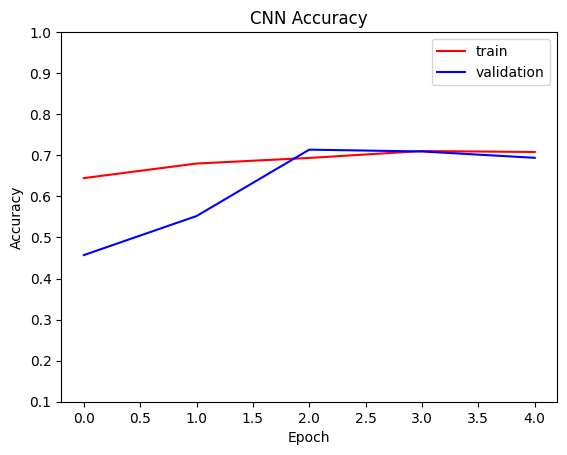

In [27]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Accuracy')
plt.ylim(0.1,1.0)
plt.legend()
plt.show()

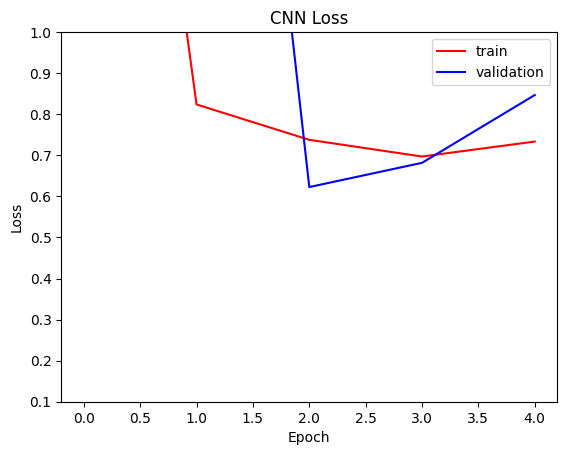

In [28]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.1,1.0)
plt.title('CNN Loss')
plt.legend()
plt.show()

# EfficientNet

Load EfficientNetB0 Model

In [29]:
basemodel=EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224,224,3))
basemodel.trainable=False
x=GlobalAveragePooling2D()(basemodel.output)
x=Dense(128,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(64,activation='relu')(x)
x=Dropout(0.5)(x)
output=Dense(3,activation='softmax')(x)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


EfficientNetB0 Model Compile

In [30]:
efficient_model=Model(inputs=basemodel.input,outputs=output)
efficient_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

EfficientNetB0 summary

In [31]:
efficient_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,221,990 (16.11 MB)

 Trainable params: 172,419 (673.51 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

EfficientNetB0 Model training

In [32]:
history_efficientnet=efficient_model.fit(train_generator,validation_data=val_generator,epochs=5)

Epoch 1/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 187s 494ms/step - accuracy: 0.6442 - loss: 0.9030 - val_accuracy: 0.6728 - val_loss: 0.8319
Epoch 2/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 145s 437ms/step - accuracy: 0.6716 - loss: 0.8487 - val_accuracy: 0.6728 - val_loss: 0.8238
Epoch 3/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 141s 425ms/step - accuracy: 0.6694 - loss: 0.8291 - val_accuracy: 0.6728 - val_loss: 0.8237
Epoch 4/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 144s 433ms/step - accuracy: 0.6738 - loss: 0.8256 - val_accuracy: 0.6728 - val_loss: 0.8232
Epoch 5/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 144s 434ms/step - accuracy: 0.6661 - loss: 0.8381 - val_accuracy: 0.6728 - val_loss: 0.8232


EfficientNetB0 Model Evaluation

In [33]:
efficient_loss, efficient_acc = efficient_model.evaluate(test_generator)
print(f"Test Accuracy: {efficient_acc*100:.2f}%")

72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.6807 - loss: 0.8132
Test Accuracy: 67.22%


EfficientNet50 Model Visualization

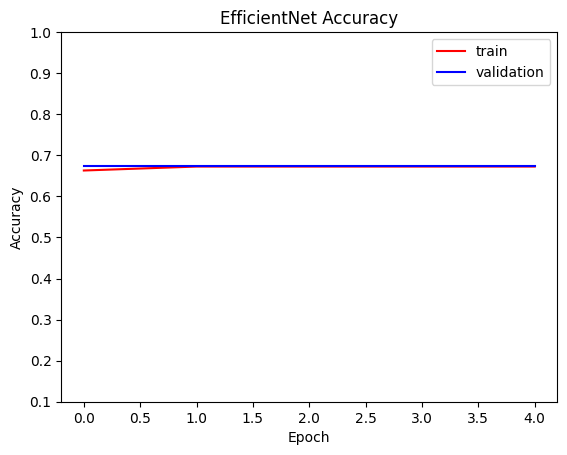

In [34]:
plt.plot(history_efficientnet.history['accuracy'],color='red',label='train')
plt.plot(history_efficientnet.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1,1.0)
plt.title('EfficientNet Accuracy')
plt.legend()
plt.show()

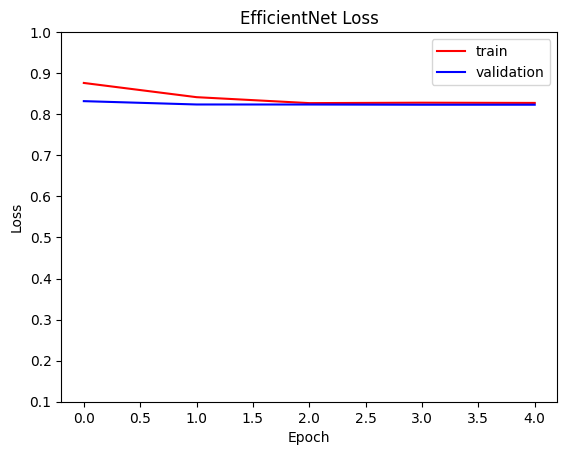

In [35]:
plt.plot(history_efficientnet.history['loss'],color='red',label='train')
plt.plot(history_efficientnet.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.1,1.0)
plt.title('EfficientNet Loss')
plt.legend()
plt.show()

# ResNet50

Load ResNet50 Model

In [36]:
basemodel=ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
basemodel.trainable=False
x=GlobalAveragePooling2D()(basemodel.output)
x=Dense(128,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(64,activation='relu')(x)
x=Dropout(0.5)(x)
output=Dense(3,activation='softmax')(x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


ResNet50 Model Compile

In [37]:
resnet_model=Model(inputs=basemodel.input,outputs=output)
resnet_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

ResNet50 Summary

In [38]:
resnet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,858,435 (91.01 MB)

 Trainable params: 270,723 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

ResNet50 Model Training

In [39]:
history_resnet=resnet_model.fit(train_generator,validation_data=val_generator,epochs=5)

Epoch 1/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 179s 499ms/step - accuracy: 0.6383 - loss: 0.9252 - val_accuracy: 0.6728 - val_loss: 0.8380
Epoch 2/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 150s 453ms/step - accuracy: 0.6653 - loss: 0.8516 - val_accuracy: 0.6728 - val_loss: 0.8231
Epoch 3/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 151s 455ms/step - accuracy: 0.6778 - loss: 0.8285 - val_accuracy: 0.6728 - val_loss: 0.8232
Epoch 4/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 153s 462ms/step - accuracy: 0.6740 - loss: 0.8292 - val_accuracy: 0.6728 - val_loss: 0.8232
Epoch 5/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 150s 452ms/step - accuracy: 0.6811 - loss: 0.8134 - val_accuracy: 0.6728 - val_loss: 0.8233


ResNet50 Model Evaluation

In [40]:
resnet_loss, resnet_acc = resnet_model.evaluate(test_generator)
print(f"Test Accuracy: {resnet_acc*100:.2f}%")

72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.6770 - loss: 0.8296
Test Accuracy: 67.22%


ResNet50 Model Visualization

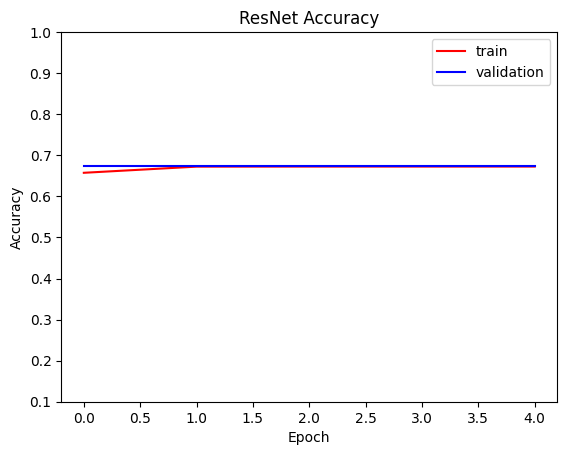

In [41]:
plt.plot(history_resnet.history['accuracy'],color='red',label='train')
plt.plot(history_resnet.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1,1.0)
plt.title('ResNet Accuracy')
plt.legend()
plt.show()

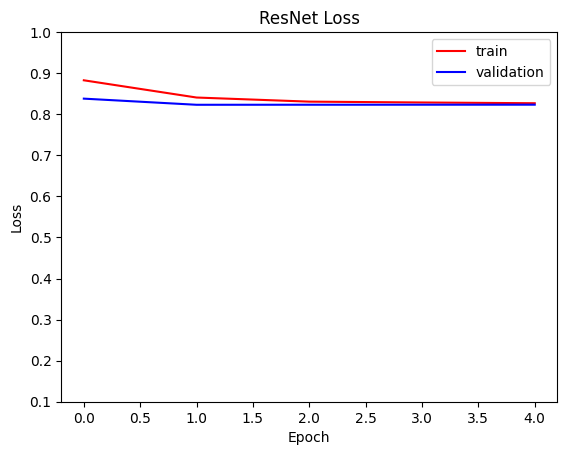

In [42]:
plt.plot(history_resnet.history['loss'],color='red',label='train')
plt.plot(history_resnet.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.1,1.0)
plt.title('ResNet Loss')
plt.legend()
plt.show()

# VGG19

Load VGG19 Model

In [12]:
basemodel=VGG19(weights='imagenet',include_top=False,input_shape=(224,224,3))
basemodel.trainable=False
x=GlobalAveragePooling2D()(basemodel.output)
x=Dense(128,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(64,activation='relu')(x)
x=Dropout(0.5)(x)
output=Dense(3,activation='softmax')(x)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


VGG19 Model Compile

In [13]:
vgg19_model=Model(inputs=basemodel.input,outputs=output)
vgg19_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

VGG19 Model summary

In [14]:
vgg19_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,098,499 (76.67 MB)

 Trainable params: 74,115 (289.51 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

VGG19 Model Training

In [15]:
history_vgg19=vgg19_model.fit(train_generator,validation_data=val_generator,epochs=5)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 204s 572ms/step - accuracy: 0.6501 - loss: 0.8458 - val_accuracy: 0.7098 - val_loss: 0.6474
Epoch 2/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 177s 532ms/step - accuracy: 0.6976 - loss: 0.6520 - val_accuracy: 0.7406 - val_loss: 0.5329
Epoch 3/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 169s 509ms/step - accuracy: 0.7252 - loss: 0.5856 - val_accuracy: 0.7785 - val_loss: 0.5079
Epoch 4/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 169s 509ms/step - accuracy: 0.7451 - loss: 0.5668 - val_accuracy: 0.8063 - val_loss: 0.4733
Epoch 5/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 176s 529ms/step - accuracy: 0.7615 - loss: 0.5319 - val_accuracy: 0.8085 - val_loss: 0.4569


VGG19 Model Evaluation

In [17]:
vgg19_loss, vgg19_acc = vgg19_model.evaluate(test_generator)
print(f"Test Accuracy: {vgg19_acc*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.8105 - loss: 0.4571
Test Accuracy: 80.58%


VGG19 Model Visualization

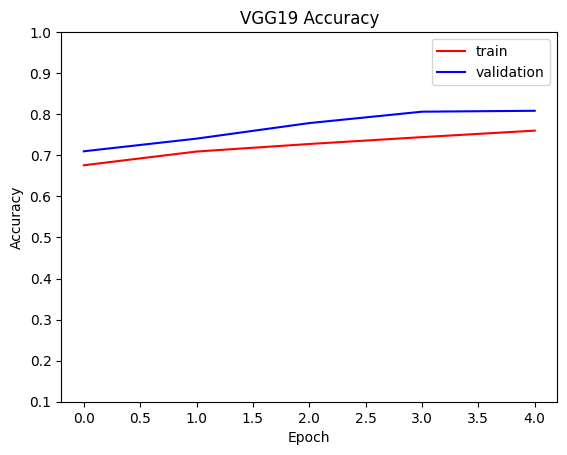

In [18]:
plt.plot(history_vgg19.history['accuracy'],color='red',label='train')
plt.plot(history_vgg19.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1,1.0)
plt.title('VGG19 Accuracy')
plt.legend()
plt.show()

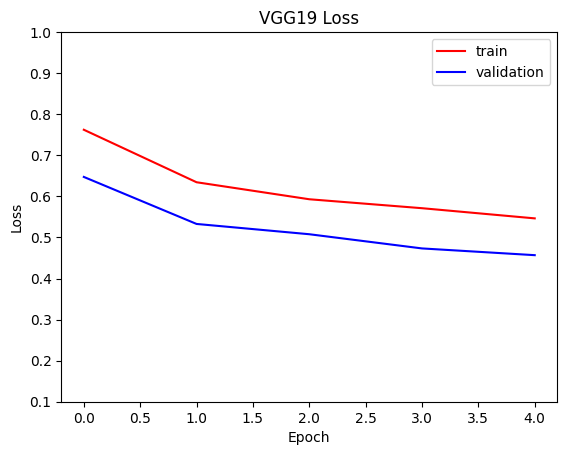

In [19]:
plt.plot(history_vgg19.history['loss'],color='red',label='train')
plt.plot(history_vgg19.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.1,1.0)
plt.title('VGG19 Loss')
plt.legend()
plt.show()

# Model Visualization

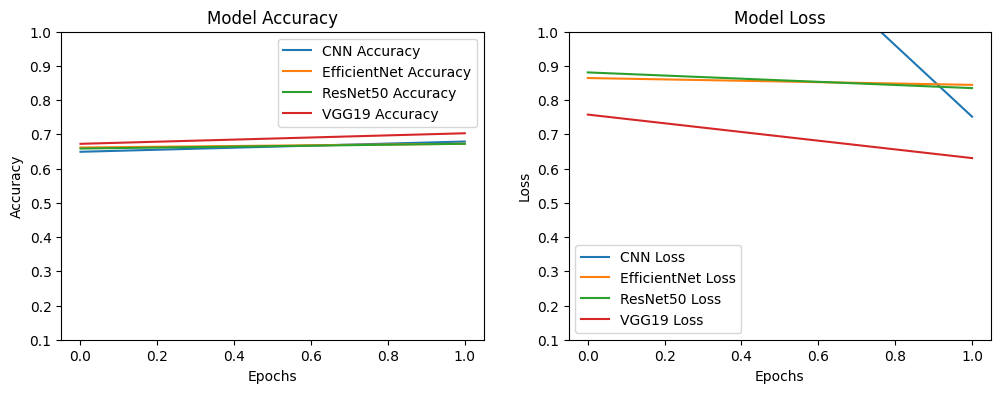

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],label='CNN Accuracy')
plt.plot(history_efficientnet.history['accuracy'], label='EfficientNet Accuracy')
plt.plot(history_resnet.history['accuracy'], label='ResNet50 Accuracy')
plt.plot(history_vgg19.history['accuracy'], label='VGG19 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1.0)
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='CNN Loss')
plt.plot(history_efficientnet.history['loss'], label='EfficientNet Loss')
plt.plot(history_resnet.history['loss'], label='ResNet50 Loss')
plt.plot(history_vgg19.history['loss'], label='VGG19 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.1, 1.0)
plt.legend()
plt.title('Model Loss')

plt.show()


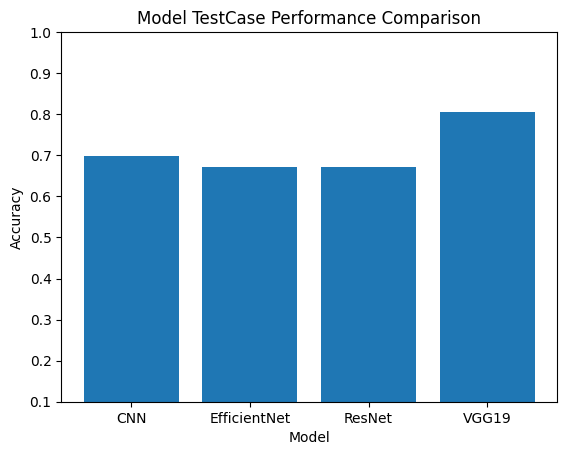

In [43]:
models = ['CNN','EfficientNet','ResNet','VGG19']
accuracies = [cnn_acc,efficient_acc,resnet_acc, vgg19_acc]
plt.bar(models, accuracies)
plt.title('Model TestCase Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1.0)
plt.show()

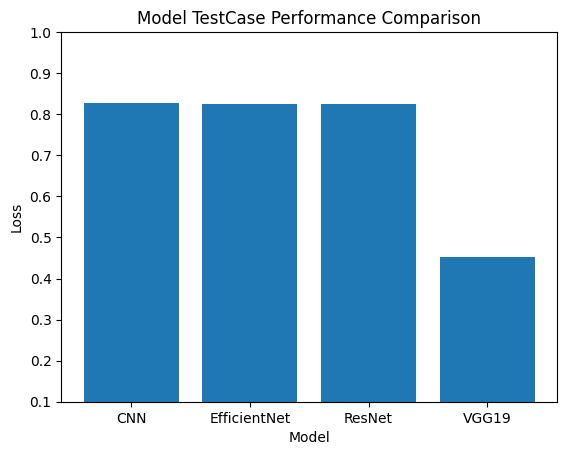

In [44]:
models = ['CNN','EfficientNet','ResNet','VGG19']
accuracies = [cnn_loss,efficient_loss,resnet_loss, vgg19_loss]
plt.bar(models, accuracies)
plt.title('Model TestCase Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.ylim(0.1, 1.0)
plt.show()

In [20]:
vgg19_model.save('covid_classifier.h5')